In [1]:
import pandas as pd
import numpy as np
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt

from pprint import pprint
pd.set_option('display.width', None)
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

# Functions

In [2]:
def drop_by_index(X,indexes):
    """
    helper function to drop rows of dataframe and return new dataframe without those rows with indexes resetted
    """
    X = X.drop(indexes)
    X = X.reset_index().drop(columns="index")
    return(X)

def build_surv_obj(survival_type, years, df_dict):
    
    #Add in filter by option param logic here:
    #
    #
    #
    
    survival_type = str(survival_type)
    years = str(years)
    
    survival_df = df_dict[years + "_years"][survival_type]
    
    Time_df = survival_df.loc[:,[survival_type + "_days"]]
    Time_df[survival_type + "_years"] = Time_df[survival_type + "_days"]/365.25
    Time_df["status"] = survival_df["status_" + survival_type]
    Time_df.head()

    return SurvivalData(time= (survival_type+ "_years"), status="status", data=Time_df)

def ComputeYears(df, Year_list):
    '''
    Create a list to contain df for different years of survival
    The df will filter those patient that has deceased or days of survival longer than the defined years.
    '''

    df_dict = {}

    for i in Year_list:
        tmp = {}
        for x in list(["DFS", "CSS", "OS"]):
            df['{}_{}_years'.format(x, i)] = np.where(
                                                      np.logical_or(df['death_age'] > 0,\
                                                      df['{}_days'.format(x)]/(365.25*i) >= i),\
                                                      True,False)
            tmp[x] = df[df['{}_{}_years'.format(x, i)] == True]
        df_dict['{}_years'.format(i)] = tmp
    return df_dict

def dataSetting(dropCol,FILE_FOLDER = "C:\\SMU_v2\\"):
    '''
    function to read the pkl from from datasource
        1. Remove dx_date that is NULL.
        2. Drop all rows where crucial fields for X_features are NULL.
        3. Convert Date columns into datetime format
        4. Derive OS, CSS, DFS days based on dx_date
        5. Create status column to indicate if the patient is dead or alive base on if death_age exists
    '''
    df = pd.read_pickle(FILE_FOLDER + "clinical_output.pkl").reset_index().drop(columns="index")
    to_drop = df[df['dx_date']=="NA"].index
    df = drop_by_index(df,to_drop)

    df.drop(columns=dropCol,inplace = True)

    # drop all rows where dates are null
    df.dropna(axis=0,\
                    subset=['Date_for_DFS','Date_for_OS','Date_for_CSS','dx_date','size_precise', 'nodespos'],\
                    inplace=True)

    # convert all datetime in dataframe into dateime format for processing
    df["Date_for_DFS"] = pd.to_datetime(df["Date_for_DFS"])
    df["Date_for_OS"] = pd.to_datetime(df["Date_for_OS"])
    df["Date_for_CSS"] = pd.to_datetime(df["Date_for_CSS"])
    df["dx_date"] = pd.to_datetime(df["dx_date"])
    df['last_seen']= pd.to_datetime(df["dx_date"])

    # calculate in days
    df["DFS_days"] = (df["Date_for_DFS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["OS_days"] = (df["Date_for_OS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["CSS_days"] = (df["Date_for_CSS"] - df['dx_date'] )/np.timedelta64(1, 'D')

    # alive or dead
    df['status_OS'] = np.where(df['Count_as_OS'] != "N", True, False)
    df['status_DFS'] = np.where(df['Count_as_DFS'] != "N", True, False)
    df['status_CSS'] = np.where(df['Count_as_CSS'] != "N", True, False)
    
    return df

### Data Processing

In [3]:
listToDrop = ['NRIC','dob','Has Bills?','Side','Hospital','KKH','NCCS','SGH']

clinical = dataSetting(listToDrop)

year_list = list([1,5,10])
df_dict = ComputeYears(clinical,year_list)

# Display shape of data after filtering
for i in df_dict:
    for s_type in df_dict[i]:
        print("Year: {}, survival category: {}, size: {}".format(i,s_type,df_dict[i][s_type].shape))
        

Year: 1_years, survival category: DFS, size: (14946, 218)
Year: 1_years, survival category: CSS, size: (15118, 219)
Year: 1_years, survival category: OS, size: (15118, 220)
Year: 5_years, survival category: DFS, size: (2816, 221)
Year: 5_years, survival category: CSS, size: (2867, 222)
Year: 5_years, survival category: OS, size: (2867, 223)
Year: 10_years, survival category: DFS, size: (2785, 224)
Year: 10_years, survival category: CSS, size: (2785, 225)
Year: 10_years, survival category: OS, size: (2785, 226)


In [4]:
df_dict["10_years"]["OS"].head()

,Gender,Race,Marital_Status,Height,Weight,Smoker,Alcohol,ECOG,comorbidity,sync_ca_date,sync_ca_desc,hx_other_ca_date,hx_other_ca_desc,parity,Oral_Contraceptive,famhx,Breast_Feed,Merche_At,Menopause_Status,Age.Menopause,First_Child_At,Hor_replacement,Presentation,Doctor_In_Charge,previous_dx_date,previous_stagingtype,Previous_T,Previous_N,Previous_M,Previous_stage,Rx_date,firstsee,dx_date,srgdate,Breast_surgery,operation_summ,Recon,Reconstruction,Surgeon,Genomic_Test,Recurrence_Score,Site,Histology,HistCode_WWXX,c_tstage,cNstage,cMstage,c_Staging,tstage,nstage,Mstage,p_Staging,Ajcc8_phyllodes_tstage,diff,TNM_Stage,ProgStage_AJCC8,AJCC8_Staging,er_intensity,er_percentage,ER,pr_intensity,pr_percentage,PR,cerbB2_intensity,cerbB2_percentage,cerbB2,FISH,fish_ratio,Her2,size_precise,Size,closet_radial_margin,Margins_mm,margins,margins_calc,Multi_focality,Multi_centricity,Extensive_Intraductal_Component,Comedo_Necrosis,Pleomorphism,VNPI,invasion,slnb,slnb_positive,no_sentinel_node,nodespos,nodesrem,False_Negative_SLNB,Non_SLN,ac,AClevel,hrt,TMX,X.1st_Tamoxifen,Last_Tamoxifen,hrt2,hrt2_desc,hrt2_start,hrt2_end,Targeted,X.1st_Herceptin,Last_Herceptin,Herceptincycles,Herceptindose_mg,Neo_Adjuvant,neo_adj_chemo_start,neo_adj_chemo_end,neo_adj_chemo_regimen_desc,neo_adj_chemo_regimen,neo_adj_chemo_cycle,neo_adj_chemo_dose,chemo,Chemo_Intent_not_neoadj,chemo_start,chemo_end,other_chemo_regimen,chemo_regimen,chemo_cycle,RT,RT_intent,technique,RT_Technique,rtstart,rtend,field,fractions,dose,scdose,midplane,intmamm,cwdose_cGy,boostdose_cGy,scdose_cGy,axdose_cGy,intmamdose_cGy,TreatmentCycleType,treatment_remarks,firstfail,First_Fail,First_Fail_Date,Second_Fail,Second_Fail_Date,Third_Fail,Third_Fail_Date,Mets.Dx,New_mets,Site_mets,remarks,New_primary,Local_Desc,Local_nontrue_desc,Nodal_recur,contra_remarks,status,lastseen,deathcode,cause_of_death,MHA_COD,Date_for_DDFS,Date_for_IBTR,Date_for_True_Local_Recurrence,Date_for_Other_Local_Recurrence,Date_for_Nodal_Recurrence,Date_for_Contra_Rec,event_dt,Date_for_DFS,Date_for_OS,Date_for_CSS,Count_as_EVENTS,Count_as_DFS,Count_as_DDFS,Count_as_IBTR,Count_as_True_Local_Recurrence,Count_as_Other_Local_Recurrence,Count_as_Nodal_Recurrence,Count_as_Contra_Rec,Count_as_OS,Count_as_CSS,chestsiz_recode,Chestsiz_dichotomise,TNM_collapse,TNM_I_vs_II,Time_OS,Time_CSS,Time_IBTR,Time_IBTRTrue,Time_DFS,Time_DDFS,Time_ContraRec,Age_@_Dx,Histo_subtype,Histo_subtype_collapse,Histo_subtype_collapser,subtype_stg2013,subtype_stg2013_lumb,Triple_Neg,resident,mastect,surgfirst,Date_for_IDFS,Date_for_DSS,Date_for_RFS,Count_as_IDFS,Count_as_DSS,Count_as_RFS,Time_IDFS,Time_DSS,Time_RFS,END_OF_ENTRY,death_age,last_seen,DFS_days,OS_days,CSS_days,status_OS,status_DFS,status_CSS,DFS_1_years,CSS_1_years,OS_1_years,DFS_5_years,CSS_5_years,OS_5_years,DFS_10_years,CSS_10_years,OS_10_years
0,female,chinese,Married (including common law),1.52,62.2,Yes,Former,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,no,No,14,Post,37,NaN,NaN,Clinical,2,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-23 00:00:00,2007-08-15 00:00:00,2007-06-12,2007-07-23 00:00:00,Breast Conservation Therapy,l breast lump wide excision,No,NaN,11,NaN,NaN,lower outer,intra ductal (DCIS),NaN,tx,nx,mx,unknown,tis,n0,m0,dcis/lcis non-invasive,NaN,grade 2,dcis/lcis non-invasive,stage 0,Stage 0,3+,NaN,positive,3+,NaN,positive,Negative,NaN,negative,Not Done,NaN,negative,4.0,3.01 to 4 cm,NaN,4,0 to 5 mm,NaN,No,No,pure DCIS,Non Comedo,NaN,non-high gd w/out comedo,no,no,0,0,0.0,0,NaN,NaN,no,NaN,Tamoxifen only,TMX,2007-10-25 00:00:00,2012-11-02 00:00:00,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NA,NaN,yes,NaN,OPP TANGENTIAL,Opp Tangential,2007-09-27 00:00:00,2007-10-24 00:00:00,breast only,15,4005 + boost 1110,no treatment,no treatment,no treatment,4005,1110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dead,2018-05-05 00:00:00,NaN,n,SPONTANEOUS LEFT BASAL GANGLIA AND THALAMIC IN...,2018-05-05 00:00:00,2018-05-05 00:00:00,2018-05-05 00

### Kaplan Meier Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

from survive import datasets
from survive import SurvivalData
from survive import KaplanMeier, Breslow, NelsonAalen

Overall Survival Modeling

Kaplan-Meier estimator

 total  events  censored
  2785    2785         0

      time  events  at risk  estimate  std. error  95% c.i. lower  95% c.i. upper
  0.030116       1     2785  0.999641    0.000359        0.997454        0.999949
  0.038330       1     2784  0.999282    0.000508        0.997132        0.999820
  0.041068       1     2783  0.998923    0.000622        0.996664        0.999652
  0.057495       1     2782  0.998564    0.000718        0.996178        0.999461
  0.062971       1     2781  0.998205    0.000802        0.995692        0.999252
  0.065708       1     2780  0.997846    0.000879        0.995211        0.999032
  0.068446       1     2779  0.997487    0.000949        0.994735        0.998801
  0.123203       1     2778  0.997127    0.001014        0.994264        0.998562
  0.150582       1     2777  0.996768    0.001075        0.993798        0.998317
  0.153320       1     2776  0.996409    0.001133        0.993337        0.998066
  0.161533       1     

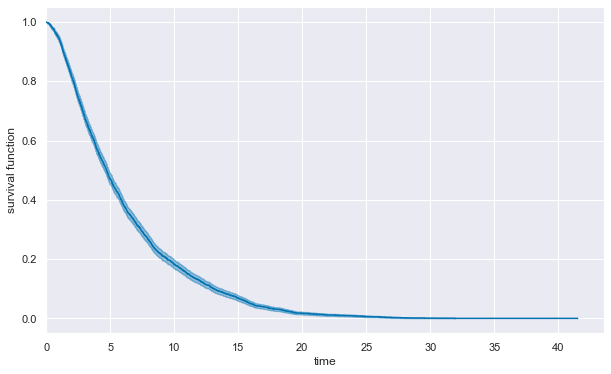

In [6]:
#Build Input DF
surv = build_surv_obj(survival_type="OS", years=10, df_dict=df_dict)
OS_km = KaplanMeier()
OS_km.fit(surv)
print(OS_km.summary)
print(OS_km)


#Plot Curve
plt.figure(figsize=(10, 6))
OS_km.plot()
plt.show()
plt.close()

Disease Free Survival

Kaplan-Meier estimator

 total  events  censored
  2615    2615         0

      time  events  at risk  estimate  std. error  95% c.i. lower  95% c.i. upper
  0.002738       2     2615  0.999235    0.000541        0.996945        0.999809
  0.008214       1     2613  0.998853    0.000662        0.996447        0.999630
  0.013689       1     2612  0.998470    0.000764        0.995930        0.999426
  0.024641       1     2611  0.998088    0.000854        0.995412        0.999204
  0.027379       2     2610  0.997323    0.001010        0.994393        0.998723
  0.032854       1     2608  0.996941    0.001080        0.993892        0.998469
  0.035592       1     2607  0.996558    0.001145        0.993396        0.998208
  0.038330       2     2606  0.995793    0.001266        0.992417        0.997668
  0.043806       2     2604  0.995029    0.001375        0.991454        0.997110
  0.046543       1     2602  0.994646    0.001427        0.990977        0.996826
  0.054757       1     

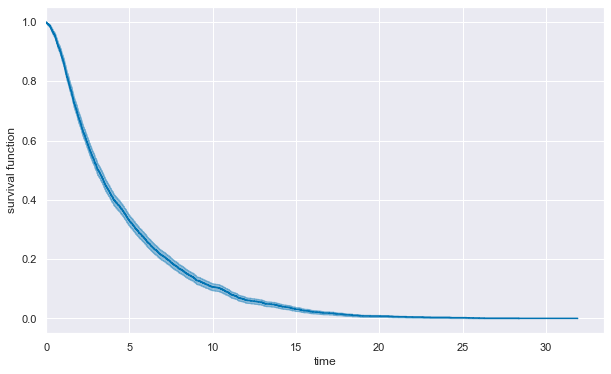

group,0
time,
0.002738,0.999235
1.000000,0.872275
2.000000,0.669598
3.000000,0.517400
4.000000,0.407648
5.000000,0.329637
6.000000,0.264245
7.000000,0.211472
8.000000,0.167495


In [7]:
#Build Input DF
surv = build_surv_obj(survival_type="DFS",years=10, df_dict=df_dict)
DFS_km = KaplanMeier()
DFS_km.fit(surv)
print(DFS_km.summary)
print(DFS_km)

#Plot curve
plt.figure(figsize=(10, 6))
DFS_km.plot()
plt.show()
plt.close()

#Estimate is basically reading off the curve at the respective time
estimate = DFS_km.predict([0.002738,1,2,3,4,5,6,7,8,9,10])
display(estimate)

Cancer Specific Survival

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')


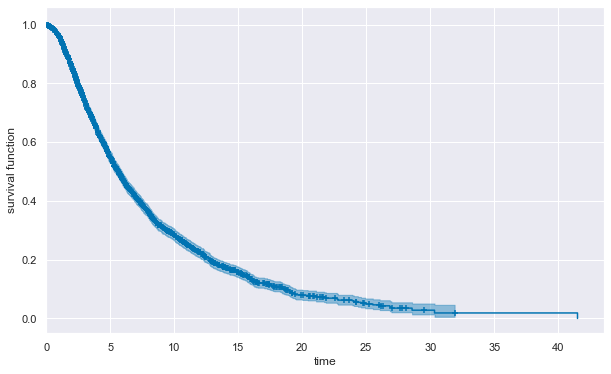

In [8]:
#Build Input DF
surv = build_surv_obj(survival_type="CSS", years=10, df_dict=df_dict)
CSS_km = KaplanMeier()
CSS_km.fit(surv)
# print(CSS_km.summary)
print(CSS_km)

#Plot curve
plt.figure(figsize=(10, 6))
CSS_km.plot()
plt.show()
plt.close()